In [ ]:
from POSEIDON.high_res import cross_correlate, log_likelihood
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
import jax
from POSEIDON.core import create_star, create_planet, define_model, make_atmosphere, read_opacities, wl_grid_constant_R, wl_grid_line_by_line, compute_spectrum
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocess import Pool # multiprocessing package somehow does not work with Jupyter notebook. See https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror

from matplotlib.pyplot import *
import time
import pickle
from scipy import constants
import numpy as np
from matplotlib.pyplot import cm
from array import *
from scipy import signal
from scipy import special
from scipy import interp
from scipy import ndimage
from astropy.io import fits
import glob
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
import matplotlib.pyplot as plt

6.122121175303471


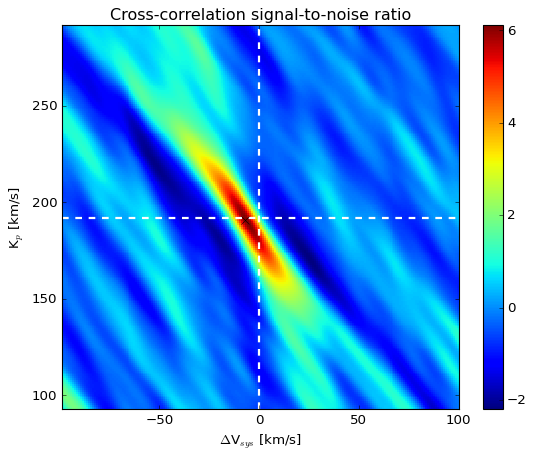

6.033572913278236


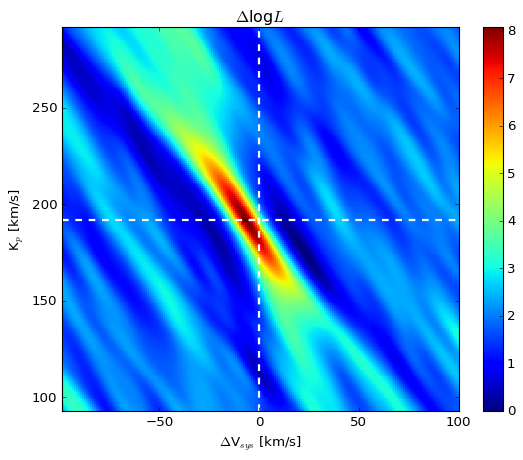

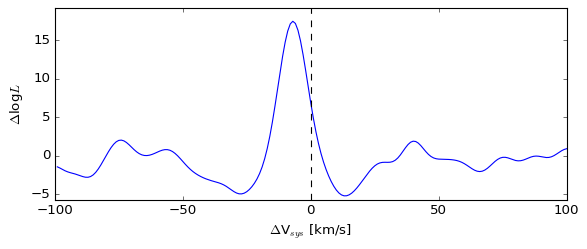

In [11]:
output_path = 'CC_output/'
name = 'BEST_FIT'
filearr = sorted(glob.glob(output_path+'/test_PCA_*.pic'))

Vsys = []
for i in range(len(filearr)):
	Vsysarr, Kparr, CCFarr, logLarr = pickle.load(open(filearr[i],'rb'), encoding='latin1')
	Vsys = np.append(Vsys, Vsysarr)

CCF = np.zeros((CCFarr.shape[0], len(Vsys)))
logL = np.zeros((CCFarr.shape[0], len(Vsys)))

curr = 0
for i in range(len(filearr)):
	Vsysarr, Kparr, CCFarr, logLarr = pickle.load(open(filearr[i],'rb'), encoding='latin1')
	CCF[:, curr:curr+CCFarr.shape[1]] = CCFarr
	logL[:, curr:curr+logLarr.shape[1]] = logLarr
	curr += CCFarr.shape[1]

# xlimm=90
# ylimm=120
CCFarr1 = CCF-np.mean(CCF)
Vsysarr = Vsys
Kp = 192.06  #orbital velocity of planet
fig, ax = subplots()

CCFarr1 = CCFarr1[::-1, :]
CCFarr1 = CCFarr1-np.mean(CCFarr1)
# stdev=np.std(CCFarr1[ylimm:-1,0:xlimm])
stdev=np.std(CCFarr1)
#CCFarr1[ylimm:-1,0:xlimm]=0
maxx = (CCFarr1/stdev).max()
print(maxx)
loc = np.where(CCFarr1/stdev == maxx)
cax = ax.imshow(CCFarr1/stdev, extent=[Vsysarr.min(), Vsysarr.max(), Kparr.min(), Kparr.max()], aspect="auto", interpolation='none')
cbar = colorbar(cax, ticks=[-4, -2, 0, 2, 4, 6, 8, 10, 12])
axvline(x = 0, color = 'white', ls = '--', lw = 2)
axhline(y = 192.06, color = 'white', ls = '--', lw = 2)
#axhline(y=193.80,color='white',ls='--',lw=2)
plot(Vsysarr[loc[1]], Kparr[::-1][loc[0]], 'xk', ms=7)
axis([Vsysarr.min(), Vsysarr.max(), Kparr.min(), Kparr.max()])
#axvline(x=Vsysarr[xlimm],color='black',ls='--',lw=2)
#axhline(y=Kparr[ylimm],color='black',ls='--',lw=2)
xlabel('$\Delta$V$_{sys}$ [km/s]')
ylabel('K$_{p}$ [km/s]')
title('Cross-correlation signal-to-noise ratio')
savefig(output_path+name+'_Kp_v_Vsys_CCF_SNR.pdf',fmt='pdf')
show()
close()

'''
##slice at Kp
slicee=CCFarr1[100,]
plot(Vsysarr,slicee)
axis([-100,100,1.1*slicee.min(),1.1*slicee.max()])
xlabel('$\Delta$V$_{sys}$ [km/s]')
ylabel('Total CCF')
axvline(x=0,ls='--',color='black')
subplots_adjust(left=0.1, right=0.9, top=0.7, bottom=0.3)
savefig(path+name+'_TOTAL_CCF_SLICE.pdf',fmt='pdf')
show()
close()
'''

#logL
CCFarr1 = logL[::-1, :]
CCFarr1 = CCFarr1-np.mean(CCFarr1)
# stdev=np.std(CCFarr1[ylimm:-1,0:xlimm])
stdev=np.std(CCFarr1)
maxx = (CCFarr1/stdev).max()
print(maxx)
loc = np.where(CCFarr1/stdev == maxx)
Vsysarr = Vsys
fig, ax = subplots()
cax = ax.imshow((CCFarr1-CCFarr1.min())/stdev, extent = [Vsysarr.min(), Vsysarr.max(), Kparr.min(), Kparr.max()], aspect="auto", interpolation='none')
cbar = colorbar(cax,ticks=[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axvline(x=0., color='white', ls='--', lw=2)
axhline(y=Kp, color='white', ls='--', lw=2)
plot(Vsysarr[loc[1]], Kparr[::-1][loc[0]], 'xk', ms=7)
axis([Vsysarr.min(), Vsysarr.max(), Kparr.min(), Kparr.max()])
xlabel('$\Delta$V$_{sys}$ [km/s]')
ylabel('K$_{p}$ [km/s]')
title('$\Delta $log$L$')
savefig(output_path+name+'_Kp_v_Vsys_LogL_SNR.pdf', fmt='pdf')
show()
close()


# slice at Kp
slicee = CCFarr1[len(CCFarr1)//2]
plot(Vsysarr, slicee)
axis([-100, 100, 1.1*slicee.min(), 1.1*slicee.max()])
xlabel('$\Delta$V$_{sys}$ [km/s]')
ylabel('$\Delta$log$L$')
axvline(x = 0, ls='--', color='black')
subplots_adjust(left=0.1, right=0.9, top=0.7, bottom=0.3)
savefig(output_path+name+'_TOTAL_logL_SLICE.pdf', fmt='pdf')
show()
close()